<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [39]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-04-08 13:51:13,337 - data_ingestion - INFO - Database engine created successfully.
2024-04-08 13:51:13,428 - data_ingestion - INFO - Query executed successfully.
2024-04-08 13:51:13,429 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-04-08 13:51:13,434 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-04-08 13:51:14,436 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts ==============================
platform linux -- Python 3.11.8, pytest-8.1.1, pluggy-1.4.0 -- /home/ultracode/.cache/pypoetry/virtualenvs/datascience-Hp-DJPih-py3.11/bin/python
cachedir: .pytest_cache
rootdir: /home/ultracode/repos/ds
configfile: pyproject.toml
plugins: anyio-4.3.0
collected 4 items                                                              

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 0.36s ===============================
Deleted sampled_field_df.csv


## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
* 16 predictors; Location, Soil_type, and Crop_type are categorical.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [17]:
dataset.columns

Index(['Field_ID', 'Elevation', 'Latitude', 'Longitude', 'Location', 'Slope',
       'Rainfall', 'Min_temperature_C', 'Max_temperature_C', 'Ave_temps',
       'Soil_fertility', 'Soil_type', 'pH', 'Pollution_level', 'Plot_size',
       'Annual_yield', 'Crop_type', 'Standard_yield'],
      dtype='object')

### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID` 

#### Options
* 31
* 29
* 17
* 16

In [25]:
# Dummy Variable Encoding for categorical variables
df_encoded = pd.get_dummies(dataset, drop_first=True)
df_encoded.columns

(5654, 31)

### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* Pollution_level
* Crop_type_tea
* Annual_yield 
* Longitude 

In [35]:
df_encoded.corr()["Standard_yield"].abs()

Field_ID                   0.030802
Elevation                  0.129248
Latitude                   0.061724
Longitude                  0.085343
Slope                      0.056991
Rainfall                   0.039217
Min_temperature_C          0.144233
Max_temperature_C          0.111649
Ave_temps                  0.006786
Soil_fertility             0.070205
pH                         0.196613
Pollution_level            0.285761
Plot_size                  0.017014
Annual_yield               0.220812
Standard_yield             1.000000
Location_Rural_Amanzi      0.032049
Location_Rural_Hawassa     0.110623
Location_Rural_Kilimani    0.014778
Location_Rural_Sokoto      0.212337
Soil_type_Peaty            0.135509
Soil_type_Rocky            0.078355
Soil_type_Sandy            0.164714
Soil_type_Silt             0.205861
Soil_type_Volcanic         0.309982
Crop_type_cassava          0.186716
Crop_type_coffee           0.222217
Crop_type_maize            0.008100
Crop_type_potato           0

### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* pH
* Soil_fertility

In [49]:
import statsmodels.api as sm
y = dataset["Standard_yield"]
X = dataset[["Slope", "Elevation", "pH", "Soil_fertility"]]

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:         Standard_yield   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          3.219e+04
Date:                Mon, 08 Apr 2024   Prob (F-statistic):                        0.00
Time:                        18:00:44   Log-Likelihood:                          4358.7
No. Observations:                5654   AIC:                                     -8709.
Df Residuals:                    5650   BIC:                                     -8683.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Slope             -0.0014      0.000     -8.392      0.000      -0.002      -0.001
Elevation          0.0001   8.16e-06     16.724      0.000       0.000       0.000
pH                -0.0042      0.002     -2.378      0.017      -0.008      -0.001
Soil_fertility     0.7858      0.021     38.089      0.000       0.745       0.826
==============================================================================
Omnibus:                        9.950   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.345
Skew:                           0.068   Prob(JB):                      0.00935
Kurtosis:                       2.855   Cond. No.                     9.19e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 9.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* Min_temperature_C and Elevation

In [56]:
df_encoded.corr()[["Plot_size","Pollution_level","Crop_type_cassava","Min_temperature_C"]] 
# 0.000100, 0.012915, -0.005827, 0.956418

,Plot_size,Pollution_level,Crop_type_cassava,Min_temperature_C
Field_ID,0.005633,-0.010793,-0.002364,0.013839
Elevation,-0.032261,0.285086,0.095462,0.956418
Latitude,-0.064183,0.289556,0.050678,0.337544
Longitude,0.065011,0.476562,0.127606,0.398923
Slope,-0.603773,0.010879,-0.047826,0.044370
Rainfall,0.092198,-0.198268,0.006320,0.052469
Min_temperature_C,-0.005503,0.235310,0.100505,1.000000
Max_temperature_C,0.018017,-0.161467,0.008833,-0.576769
Ave_temps,0.015914,0.035383,0.106567,0.278994
Soil_fertility,-0.320810,-0.160151,-0.027643,0.072797


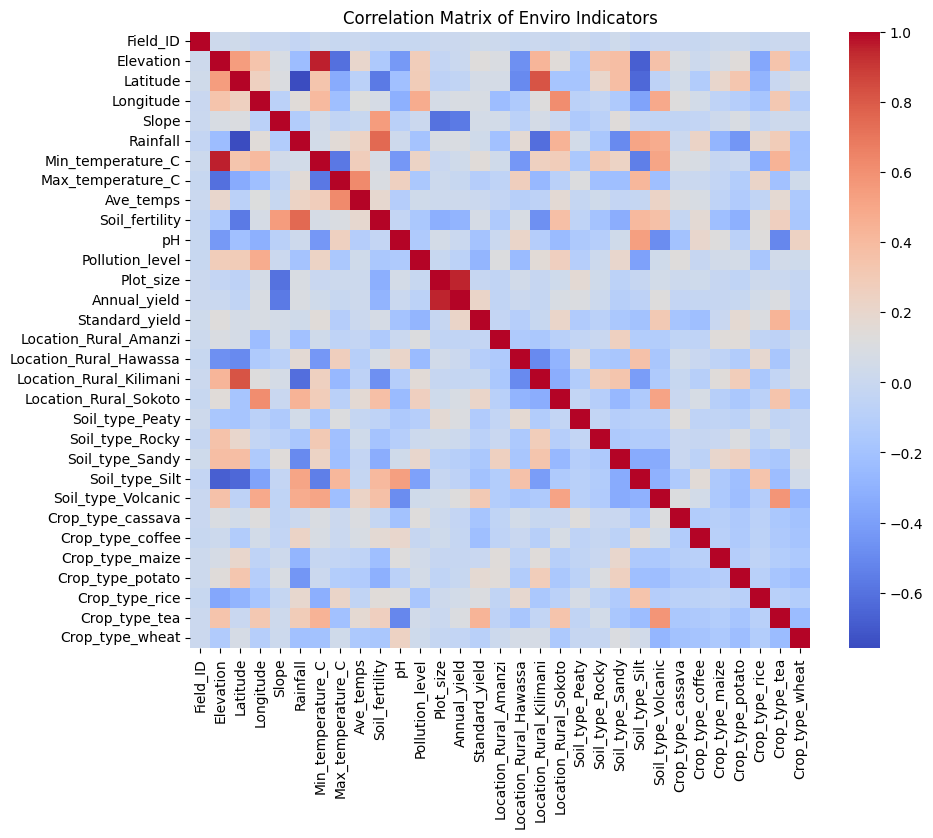

In [52]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Enviro Indicators')
plt.show()

### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [59]:
def create_formula(data, dependent_variable, exclude=[]):
  """
  Creates a formula string for OLS regression from a Pandas DataFrame.

  Args:
      data (pd.DataFrame): The DataFrame containing the data.
      dependent_variable (str): The name of the dependent variable.
      exclude (list, optional): A list of column names to exclude from the formula.
          Defaults to [].

  Returns:
      str: The formula string for OLS regression.
  """

  # Get all independent variables (excluding dependent and excluded variables)
  independent_variables = [col for col in data.columns if col != dependent_variable and col not in exclude]

  # Join independent variables with plus signs for the formula
  formula = f"{dependent_variable} ~ {' + '.join(independent_variables)}"

  return formula


formula = create_formula(df_encoded, 'Standard_yield', exclude=['Field_ID'])
print(formula)  # Output: rating ~ price + size

smf.ols(formula,df_encoded).fit().summary()

Standard_yield ~ Elevation + Latitude + Longitude + Slope + Rainfall + Min_temperature_C + Max_temperature_C + Ave_temps + Soil_fertility + pH + Pollution_level + Plot_size + Annual_yield + Location_Rural_Amanzi + Location_Rural_Hawassa + Location_Rural_Kilimani + Location_Rural_Sokoto + Soil_type_Peaty + Soil_type_Rocky + Soil_type_Sandy + Soil_type_Silt + Soil_type_Volcanic + Crop_type_cassava + Crop_type_coffee + Crop_type_maize + Crop_type_potato + Crop_type_rice + Crop_type_tea + Crop_type_wheat


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:35:11   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.6982      0.183      3.806      0.000       0.339       1.058
Location_Rural_Amanzi[T.True]       0.0062      0.005      1.325      0.185      -0.003       0.015
Location_Rural_Hawassa[T.True]     -0.0001      0.003     -0.040      0.968      -0.007       0.007
Location_Rural_Kilimani[T.True]     0.0128      0.004      3.111      0.002       0.005       0.021
Location_Rural_Sokoto[T.True]       0.0355      0.005      7.570      0.000       0.026       0.045
Soil_type_Peaty[T.True]            -0.0963      0.006    -16.784      0.000      -0.108      -0.085
Soil_type_Rocky[T.True]            -0.1022      0.005    -19.741      0.000      -0.112      -0.092
Soil_type_Sandy[T.True]            -0.0744      0.003    -23.917      0.000      -0.081      -0.068
Soil_type_Silt[T.True]             -0.1178      0.005    -25.492      0.000      -0.127      -0.109
Soil_type_Volcanic[T.True]         -0.0534      0.004    -12.605      0.000      -0.062      -0.045
Crop_type_cassava[T.True]           0.0344      0.003      9.842      0.000       0.028       0.041
Crop_type_coffee[T.True]           -0.0029      0.003     -0.891      0.373      -0.009       0.004
Crop_type_maize[T.True]             0.0505      0.004     11.792      0.000       0.042       0.059
Crop_type_potato[T.True]            0.0998      0.004     26.015      0.000       0.092       0.107
Crop_type_rice[T.True]              0.1011      0.004     23.605      0.000       0.093       0.110
Crop_type_tea[T.True]               0.1162      0.004     31.166      0.000       0.109       0.123
Crop_type_wheat[T.True]             0.0468      0.003     15.040      0.000       0.041       0.053
Elevation                       -6.517e-05      0.000     -0.628      0.530      -0.000       0.000
Latitude                           -0.0023      0.001     -3.372      0.001      -0.004      -0.001
Longitude                          -0.0014      0.001     -2.088      0.037      -0.003   -8.32e-05
Slope                               0.0014      0.001      1.769      0.077      -0.000       0.003
Rainfall                          4.27e-05   2.24e-05      1.906      0.057   -1.21e-06    8.66e-05
Min_temperature_C                   0.0121      0.010      1.273      0.203      -0.007       0.031
Max_temperature_C                  -0.0026      0.002     -1.328      0.184      -0.006       0.001
Ave_temps                           0.0048      0.004      1.250      0.211      -0.003       0.012
Soil_fertility                     -0.3560      0.257     -1.383      0.167      -0.861       0.149
pH                                  0.0206      0.001     14.509      0.000       0.018       0.023
Pollution_level                    -0.1665      0.005    -35.319      0.000      -0

### Question 8 

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* The model worsened.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [64]:
independent = df_encoded[["Field_ID", "Standard_yield", "Crop_type_tea", "Soil_type_Volcanic","Pollution_level", "Crop_type_coffee", "Annual_yield", "Location_Rural_Sokoto", "Soil_type_Silt"]]

formula = create_formula(independent, 'Standard_yield', exclude=['Field_ID'])
print(formula)  # Output: rating ~ price + size

model=smf.ols(formula,independent).fit()
model.summary()

Standard_yield ~ Crop_type_tea + Soil_type_Volcanic + Pollution_level + Crop_type_coffee + Annual_yield + Location_Rural_Sokoto + Soil_type_Silt


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Mon, 08 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:53:08   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.5690      0.003    212.947      0.000       0.564       0.574
Crop_type_tea[T.True]             0.0931      0.004     23.626      0.000       0.085       0.101
Soil_type_Volcanic[T.True]       -0.0127      0.004     -3.288      0.001      -0.020      -0.005
Crop_type_coffee[T.True]         -0.0556      0.004    -14.370      0.000      -0.063      -0.048
Location_Rural_Sokoto[T.True]     0.0647      0.004     16.768      0.000       0.057       0.072
Soil_type_Silt[T.True]           -0.0693      0.003    -21.619      0.000      -0.076      -0.063
Pollution_level                  -0.2237      0.006    -37.672      0.000      -0.235      -0.212
Annual_yield                      0.0071      0.001     11.824      0.000       0.006       0.008
==============================================================================
Omnibus:                      111.561   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.254
Skew:                          -0.348   Prob(JB):                     3.46e-26
Kurtosis:                       2.880   Cond. No.                         17.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

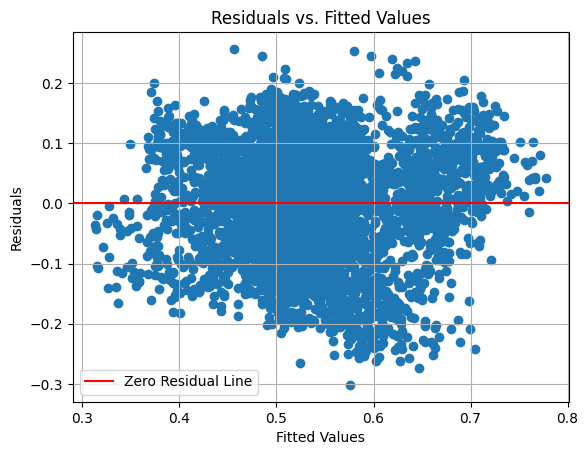

In [66]:
# Get fitted values and residuals
fitted_values = model.fittedvalues
residuals = model.resid

# Create the scatter plot
plt.scatter(fitted_values, residuals)

# Add labels and title
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")

# Add a horizontal line at y=0 for the zero residual line
plt.axhline(y=0, color='r', linestyle='-', label='Zero Residual Line')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* All of the above.

## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [68]:
from sklearn.preprocessing import StandardScaler

# Create the 'Temperature_Range' feature
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [ ]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`
* `scoring='neg_mean_squared_error`

In [69]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas=[0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)` 
* `poly = PolynomialFeatures(degree=1, include_bias=False)` 
* `poly = PolynomialFeatures(degree=3, include_bias=True)` 
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [70]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
#Insert selected option here
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape


(5654, 5)

### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

In [71]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_


array([-0.13661379,  0.10262221, -0.07348657])

## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* 0.48494414
* 0.8050340

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Assuming your encoded dataset is in a pandas DataFrame named 'data'

# Define features (excluding Standard_yield and Field_ID)
features = [col for col in df_encoded.columns if col not in ['Standard_yield', 'Field_ID']]

# Separate dependent and independent variables
X = df_encoded[features]
y = df_encoded['Standard_yield']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the DecisionTreeRegressor model
model = DecisionTreeRegressor(max_depth=2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Sample input for prediction
x = [864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,
     16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 
     0.0,0.0,0.0,0.0,0.0]

# Make a prediction
predicted_y = model.predict([x])[0]

# Print the predicted value
print("Predicted value of y:", predicted_y)


Predicted value of y: 0.48494414306304917


/home/ultracode/.cache/pypoetry/virtualenvs/datascience-Hp-DJPih-py3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* 0.0881
* 0.5656
* 0.8810

In [77]:
from sklearn.metrics import mean_squared_error

# Assuming you have already trained the model (X_train, X_test, y_train, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)  # squared=False for root calculation

# Print the RMSE value
print("RMSE:", rmse)

RMSE: 0.08805783663217344


/home/ultracode/.cache/pypoetry/virtualenvs/datascience-Hp-DJPih-py3.11/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

### Question 19 
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.


In [ ]:
# Your code here

### Question 20 
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* True
* False

In [ ]:
# Your code here

## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21 
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# Calculate average prediction across all bootstrap samples
y_pred_bagged = np.mean(predictions, axis=0)

# Calculate Mean Squared Error (MSE) of the bagged model
mse_bagged = mean_squared_error(y, y_pred_bagged)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")


Mean Squared Error of Bagged Linear Regression Models: 0.010840460793910881


Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)` 

    ### Question 22 
    
    Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?
    
    #### Options
    * `max_depth`
    * `random_state`
    * `max_features`
    * `n_estimators`

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")

Mean Squared Error of Random Forest Regressor: 0.0011131523922190431


### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`
* `lin`
* `sigmoid`
* `degree=1`

In [82]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='_____'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [83]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE\\
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [84]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Elevation, Importance: 0.3182336568013684
Feature: Slope, Importance: 0.2180406520113444
Feature: Soil_fertility, Importance: 0.1552338684281262
Feature: Pollution_level, Importance: 0.30849182275916115


## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* R2: 0.9586, MSE: 0.0006
* R2: 0.8196, MSE: 0.0500

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def train_rf_model(rf_regressor, X, y):
  """
  Trains a random forest model and evaluates its performance on a test set.

  Args:
      rf_regressor (RandomForestRegressor): The random forest model object.
      X (pandas.DataFrame): The feature data.
      y (pandas.Series): The target variable.

  Returns:
      tuple: A tuple containing the trained model, R-squared score, and MSE on the test set.
  """
  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train the model
  rf_regressor.fit(X_train, y_train)

  # Make predictions on the testing set
  y_pred = rf_regressor.predict(X_test)

  # Calculate evaluation metrics
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  return rf_regressor, r2, mse

# Example usage (assuming you have your encoded data in X and y)
rf_model = RandomForestRegressor(random_state=42, max_depth=15)
trained_model, r2, mse = train_rf_model(rf_model, X, y)

print("R-squared:", r2)
print("Mean Squared Error:", mse)

R-squared: 0.4169845765208894
Mean Squared Error: 0.00776892899787284


### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* There was no change in the error.

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def train_rf_model(rf_regressor, X, y):
  """
  Trains a random forest model and evaluates its performance on a test set.

  Args:
      rf_regressor (RandomForestRegressor): The random forest model object.
      X (pandas.DataFrame): The feature data.
      y (pandas.Series): The target variable.

  Returns:
      tuple: A tuple containing the trained model, R-squared score, and MSE on the test set.
  """
  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train the model
  rf_regressor.fit(X_train, y_train)

  # Make predictions on the testing set
  y_pred = rf_regressor.predict(X_test)

  # Calculate evaluation metrics
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)

  return rf_regressor, r2, mse

# Example usage (assuming you have your encoded data in X and y)
# Model with 150 trees
rf_model1 = RandomForestRegressor(n_estimators=150, random_state=42)
trained_model1, r2_150, mse_150 = train_rf_model(rf_model1, X, y)

# Model with 200 trees
rf_model2 = RandomForestRegressor(n_estimators=200, random_state=42)
trained_model2, r2_200, mse_200 = train_rf_model(rf_model2, X, y)

# Print the results
print("Model with 150 trees:")
print("R-squared:", r2_150)
print("Mean Squared Error:", mse_150)

print("\nModel with 200 trees:")
print("R-squared:", r2_200)
print("Mean Squared Error:", mse_200)

# Compare errors (lower MSE indicates better performance)
if mse_150 < mse_200:
  print("The error increased when the number of trees was increased from 150 to 200.")
elif mse_150 > mse_200:
  print("The model with 200 trees showed a slight decrease in error compared to the model with 150 trees.")
else:
  print("There was no change in the error.")

Model with 150 trees:
R-squared: 0.4092584729659612
Mean Squared Error: 0.007871882620592224

Model with 200 trees:
R-squared: 0.40541535423990815
Mean Squared Error: 0.007923093815546437
The error increased when the number of trees was increased from 150 to 200.


### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* Rainfall, Crop_type_tea, Latitude
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [87]:
from sklearn.ensemble import RandomForestRegressor

# Assuming you have the trained model with 200 trees (trained_model2 from previous example)

# Extract feature importances
feature_importances = trained_model2.feature_importances_

# Sort feature importances with features (assuming feature names are in X.columns)
importance_tuples = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print the top 3 most important features
print("Top 3 Most Important Features:")
for i in range(3):
  feature, importance = importance_tuples[i]
  print(f"{i+1}. {feature} (Importance: {importance:.4f})")

Top 3 Most Important Features:
1. Elevation (Importance: 0.3227)
2. Pollution_level (Importance: 0.3081)
3. Slope (Importance: 0.2141)


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>